# Sepsis ML Model - Building an API using Fast API

## `Business Understanding`

### Goal: The goal is to develop a machine learning model that accurately predicts whether a patient in the ICU will develop sepsis or not based on their medical attributes. This model can be used by healthcare professionals to identify high-risk patients early and provide timely interventions, potentially reducing the morbidity and mortality associated with sepsis. Additionally, understanding the key predictors of sepsis development can inform targeted interventions and resource allocation in ICU settings.

## ``Hypothesis``
### Null Hypothesis (H0): There is no significant difference in blood work results for patients who develop sepsis compared to those who do not
### Alternative Hypothesis (H1): There is a significant difference in blood work results for patients who develop sepsis compared to those who do not

## `Analytical Questions`
### 1. How does the distribution of each attribute differ between patients who develop sepsis and those who do not?
### 2. Is there a correlation between BMI and the risk of developing sepsis?
### 3. Does the duration of ICU stay differ between patients who develop sepsis and those who do not?
### 4. How does the distribution of body mass index (BMI) differ between patients who have insurance and those who do not?
### 5. Is there a significant difference in the average age between patients who develop sepsis and those who do not?
### 6. Is there a correlation between BMI and the risk of developing sepsis?

---

### Features

> ID : Unique number to represent patient 
>  
> PL : Blood Work Result-1 (mu U/ml) 
>
> PRG : Plasma glucose
>
> SK : Blood Work Result-2 (mm)
>  
> PR : Blood Pressure (mm Hg)
>
> TS : Blood Work Result-3 (mu U/ml)
>
> M11 : Body mass index (weight in kg/(height in m)^2
>
> BD2 : Blood Work Result-4 (mu U/ml)
>
> Age : patients age  (years)
>
> Insurance : If a patient holds a valid insurance card
>
> Sepssis : Positive: if a patient in ICU will develop a sepsis , and Negative: otherwise

## `Data Understanding`

In [2]:
# Importing relevant libraries
import re
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings 
warnings.filterwarnings('ignore')
import joblib

#importing visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from numpy import log1p
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix


---

## `Loading Data`

In [3]:
#load test data
df_test = pd.read_csv('Paitients_Files_Test.csv')
df_test.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0


In [4]:
#load  train data
df_train = pd.read_csv('Paitients_Files_Train.csv')
df_train.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   PL         169 non-null    int64  
 3   PR         169 non-null    int64  
 4   SK         169 non-null    int64  
 5   TS         169 non-null    int64  
 6   M11        169 non-null    float64
 7   BD2        169 non-null    float64
 8   Age        169 non-null    int64  
 9   Insurance  169 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 13.3+ KB


In [6]:
df_test['Insurance'] = df_test['Insurance'].replace({0: 'No', 1: 'Yes'})
df_test['Insurance'] = df_test['Insurance'].astype(str)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [8]:
df_train['Insurance'] = df_train['Insurance'].replace({0: 'No', 1: 'Yes'})
df_train['Insurance'] = df_train['Insurance'].astype(str)

In [9]:
# Summary Statistics
print("\nSummary statistics:")
print(df_test.describe().T)


Summary statistics:
     count        mean         std   min      25%      50%      75%      max
PRG  169.0    3.917160    3.402415   0.0    1.000    3.000    6.000   13.000
PL   169.0  123.520710   29.259123  56.0  102.000  120.000  141.000  199.000
PR   169.0   70.426036   19.426805   0.0   62.000   74.000   80.000  114.000
SK   169.0   20.443787   15.764962   0.0    0.000   23.000   32.000   49.000
TS   169.0   81.000000  110.720852   0.0    0.000    0.000  135.000  540.000
M11  169.0   32.249704    7.444886   0.0   27.600   32.400   36.600   57.300
BD2  169.0    0.438876    0.306935   0.1    0.223    0.343    0.587    1.698
Age  169.0   33.065089   11.548110  21.0   24.000   28.000   42.000   70.000


In [10]:
# Summary Statistics
print("\nSummary statistics:")
print(df_train.describe().T)


Summary statistics:
     count        mean         std     min     25%      50%      75%     max
PRG  599.0    3.824708    3.362839   0.000   1.000    3.000    6.000   17.00
PL   599.0  120.153589   32.682364   0.000  99.000  116.000  140.000  198.00
PR   599.0   68.732888   19.335675   0.000  64.000   70.000   80.000  122.00
SK   599.0   20.562604   16.017622   0.000   0.000   23.000   32.000   99.00
TS   599.0   79.460768  116.576176   0.000   0.000   36.000  123.500  846.00
M11  599.0   31.920033    8.008227   0.000  27.100   32.000   36.550   67.10
BD2  599.0    0.481187    0.337552   0.078   0.248    0.383    0.647    2.42
Age  599.0   33.290484   11.828446  21.000  24.000   29.000   40.000   81.00


#### Insights
1. The data set has relatively different scales

In [11]:
# Check for duplicated rows if any 
df_train.duplicated().sum()

0

In [12]:
# Check for duplicated rows if any 
df_test.duplicated().sum()

0

In [13]:
# check unique values
unique_values_per_column = df_train.apply(pd.unique)
print(unique_values_per_column)

ID           [ICU200010, ICU200011, ICU200012, ICU200013, I...
PRG          [6, 1, 8, 0, 5, 3, 10, 2, 4, 7, 9, 11, 13, 15,...
PL           [148, 85, 183, 89, 137, 116, 78, 115, 197, 125...
PR           [72, 66, 64, 40, 74, 50, 0, 70, 96, 92, 80, 60...
SK           [35, 29, 0, 23, 32, 45, 19, 47, 38, 30, 41, 33...
TS           [0, 94, 168, 88, 543, 846, 175, 230, 83, 96, 2...
M11          [33.6, 26.6, 23.3, 28.1, 43.1, 25.6, 31.0, 35....
BD2          [0.627, 0.351, 0.672, 0.167, 2.288, 0.201, 0.2...
Age          [50, 31, 32, 21, 33, 30, 26, 29, 53, 54, 34, 5...
Insurance                                            [No, Yes]
Sepssis                                   [Positive, Negative]
dtype: object


In [14]:
# check unique values
unique_values_per_column = df_test.apply(pd.unique)
print(unique_values_per_column)

ID           [ICU200609, ICU200610, ICU200611, ICU200612, I...
PRG             [1, 6, 7, 4, 0, 3, 11, 2, 9, 5, 10, 13, 8, 12]
PL           [109, 108, 96, 124, 150, 183, 181, 92, 152, 11...
PR           [38, 88, 0, 74, 78, 60, 62, 82, 54, 58, 80, 72...
SK           [18, 19, 0, 36, 29, 32, 42, 25, 39, 13, 21, 22...
TS           [120, 0, 126, 293, 41, 272, 182, 158, 194, 321...
M11          [23.1, 27.1, 23.7, 27.8, 35.2, 28.4, 35.8, 40....
BD2          [0.407, 0.4, 0.19, 0.1, 0.692, 0.212, 0.514, 1...
Age          [26, 24, 28, 30, 54, 36, 21, 22, 25, 27, 23, 4...
Insurance                                            [Yes, No]
dtype: object


In [15]:
df_train.describe(include= 'object').T

,count,unique,top,freq
ID,599,599,ICU200010,1
Insurance,599,2,Yes,411
Sepssis,599,2,Negative,391


---

### `Fixing Data`

In [16]:
#drop  ID.
del df_train['ID']

### `Univariate Data Analysis`

<Figure size 1200x800 with 0 Axes>

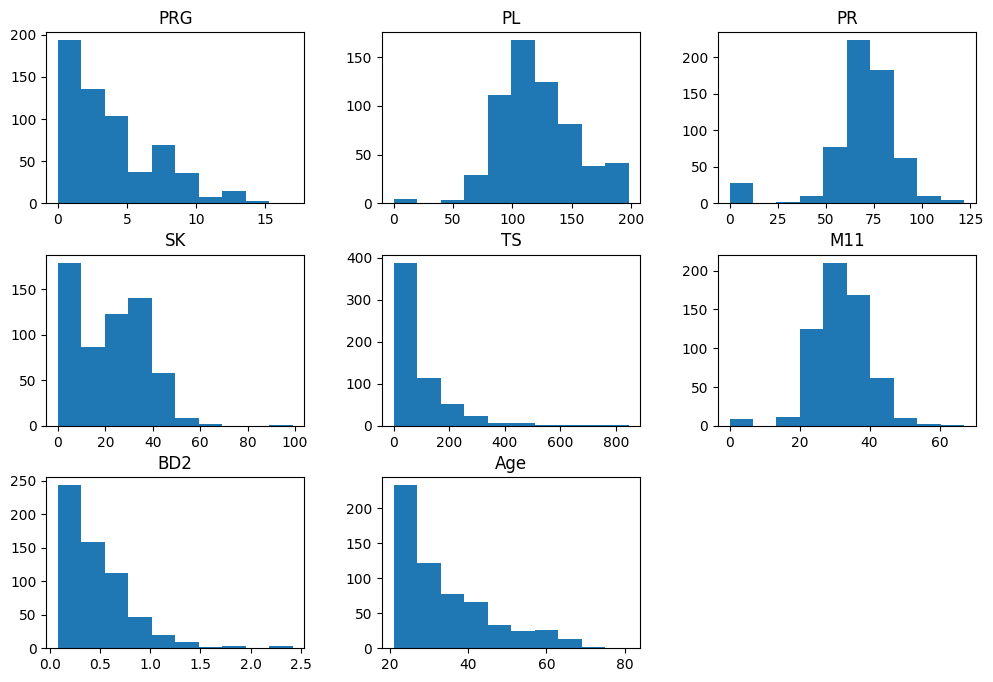

In [17]:
# Visualizing the distribution of Numerical Variables

plt.figure(figsize=(12, 8))
df_train.hist(figsize=(12,8), grid=False)
plt.title('Distribution of Numerical Variables')
histogram_fig = plt.gcf()

#### Insights
1. SK: The distribution appears skewed to the right, with more data points concentrated on the lower end and a longer tail extending towards higher values. This suggests that most patients have lower SK values, with a few having significantly higher values.
2. TS: Similar to SK, the TS distribution is also skewed to the right. There's a higher concentration of data points on the lower end with a tail extending towards higher values.
3. M11: The distribution of M11 values appears more symmetrical, with a peak around the center and data points tapering off on either side. This suggests a more normal distribution of body mass index values in the data set.
4. BD2: The BD2 distribution is skewed to the right, similar to SK and TS. There seems to be a concentration of values on the lower end with a tail extending towards higher values.
5. Age: The distribution of Age appears skewed to the right as well. There's a possibility that there are more younger patients with a smaller number of older patients.
6. PRG: The PRG distribution also appears skewed to the right. There might be more patients with lower Plasma Glucose levels and a smaller number with significantly higher levels.

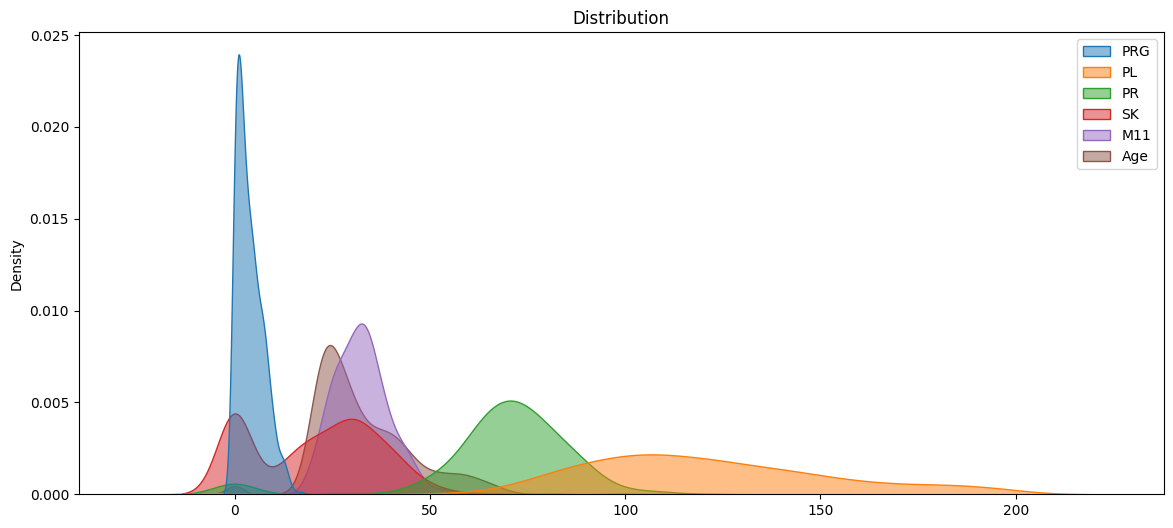

In [18]:
plt.figure(figsize=(14,6))
sns.kdeplot(df_train.drop(['BD2', 'TS'], axis=1),fill=True, alpha=0.5 )
plt.title('Distribution')
plt.show()

---

### `Checking for outliers`

In [19]:
traces = []
for col in df_train.columns:
    if col not in ['BD2', 'TS', 'Insurance','Sepssis']:  # Exclude 'BD2' and 'TS' columns
        trace = go.Box(y=df_train[col], name=col)
        traces.append(trace)

# Create layout
layout = go.Layout(
    title='Boxplot of Numerical Variables',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Value')
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show figure
fig.show()

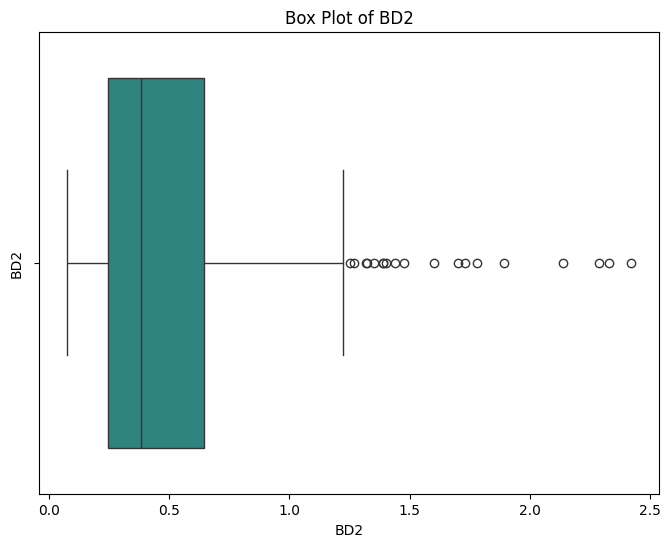

In [20]:
# Box Plot of BD2
plt.figure(figsize=(8, 6))
boxplot_total_charges= sns.boxplot(x=df_train['BD2'], orient='v', palette='viridis')
plt.title('Box Plot of BD2')
plt.ylabel('BD2')
boxplot_total_charges_fig = plt.gcf()

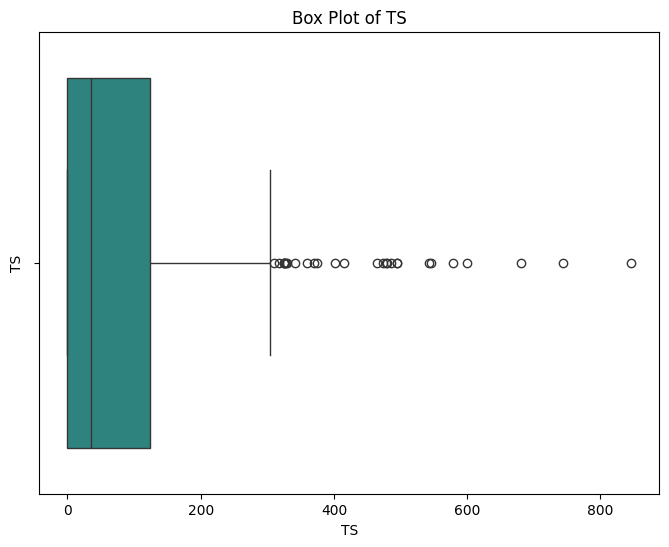

In [21]:
# Box Plot of TS
plt.figure(figsize=(8, 6))
boxplot_total_charges= sns.boxplot(x=df_train['TS'], orient='v', palette='viridis')
plt.title('Box Plot of TS')
plt.ylabel('TS')
boxplot_total_charges_fig = plt.gcf()

---

### `Bivariate Analysis`

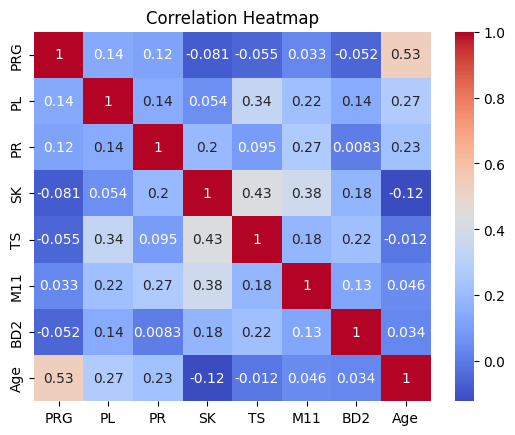

In [22]:
# Drop non-numeric columns if needed
numeric_df = df_train.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

#### Insights
##### Strong positive correlations:

1. Age and BD2 (Blood Work Result-4): There is a strong positive correlation between a patient's age and their BD2 blood test result. This means that as a patient's age increases, their BD2 blood test result also tends to increase.
2. Age and SK (Blood Work Result-2): There is also a positive correlation between age and SK.
3. SK and BD2: These two blood work results are also positively correlated.
4. Strong negative correlations: There appear to be no strong negative correlations in this heatmap.

##### Weak correlations:

1. Age and PRG (Plasma Glucose): There is a weak positive correlation between a patient's age and their PRG blood test result. This means that as a patient's age increases, their PRG level may also tend to increase, but the correlation is weak.


---

### `Answering Analytical Questions`

#### How does the distribution of each attribute differ between patients who develop sepsis and those who do not?

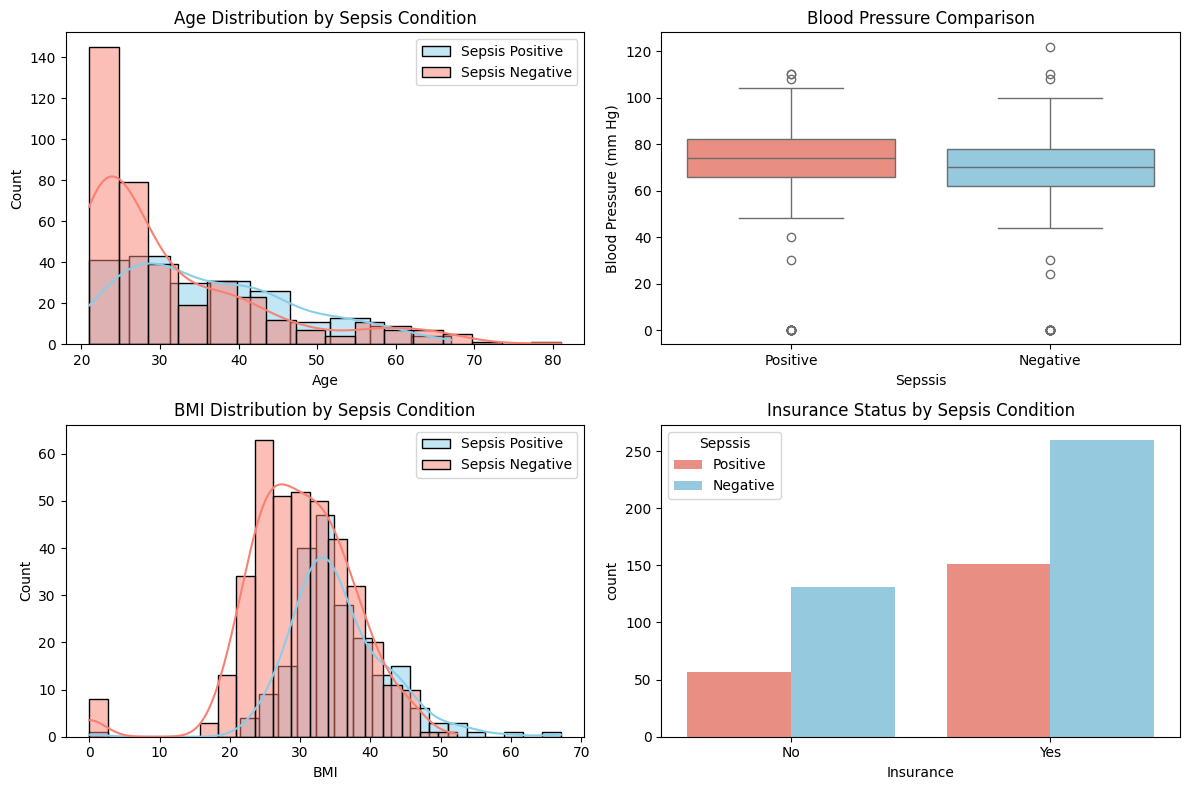

In [23]:

df = pd.DataFrame(df_train)

# Separate data by sepsis condition
sepsis_positive = df[df["Sepssis"] == "Positive"]
sepsis_negative = df[df["Sepssis"] == "Negative"]

# Create visualizations
plt.figure(figsize=(12, 8))

# Age distribution
plt.subplot(2, 2, 1)
sns.histplot(data=sepsis_positive, x="Age", kde=True, color="skyblue", label="Sepsis Positive")
sns.histplot(data=sepsis_negative, x="Age", kde=True, color="salmon", label="Sepsis Negative")
plt.xlabel("Age")
plt.title("Age Distribution by Sepsis Condition")
plt.legend()

# Blood pressure comparison
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x="Sepssis", y="PR", palette=["salmon", "skyblue"])
plt.ylabel("Blood Pressure (mm Hg)")
plt.title("Blood Pressure Comparison")

# BMI distribution
plt.subplot(2, 2, 3)
sns.histplot(data=sepsis_positive, x="M11", kde=True, color="skyblue", label="Sepsis Positive")
sns.histplot(data=sepsis_negative, x="M11", kde=True, color="salmon", label="Sepsis Negative")
plt.xlabel("BMI")
plt.title("BMI Distribution by Sepsis Condition")
plt.legend()

# Insurance status
plt.subplot(2, 2, 4)
sns.countplot(data=df, x="Insurance", hue="Sepssis", palette=["salmon", "skyblue"])
plt.xlabel("Insurance")
plt.title("Insurance Status by Sepsis Condition")

plt.tight_layout()
plt.show()
   

##### Insights
##### Age Distribution
>Notably, there seems to be a higher frequency of younger patients (below 40 years) in the sepsis-negative group, whereas the sepsis-positive group has a broader age range.
##### Blood Pressure comparison
>Sepsis-positive patients tend to have slightly higher blood pressure values compared to sepsis-negative patients.
##### BMI Distribution
The sepsis-positive group has a wider spread of BMI values, including some higher values.
>Sepsis-negative patients appear to have a more concentrated BMI distribution around the mid-range.
##### Insurance Status
>Interestingly, the majority of patients in both groups have insurance.
>However, the sepsis-positive group has a slightly higher proportion of insured patients.

#### Question 2: Is there a correlation between BMI and the risk of developing sepsis?

['Positive' 'Negative']


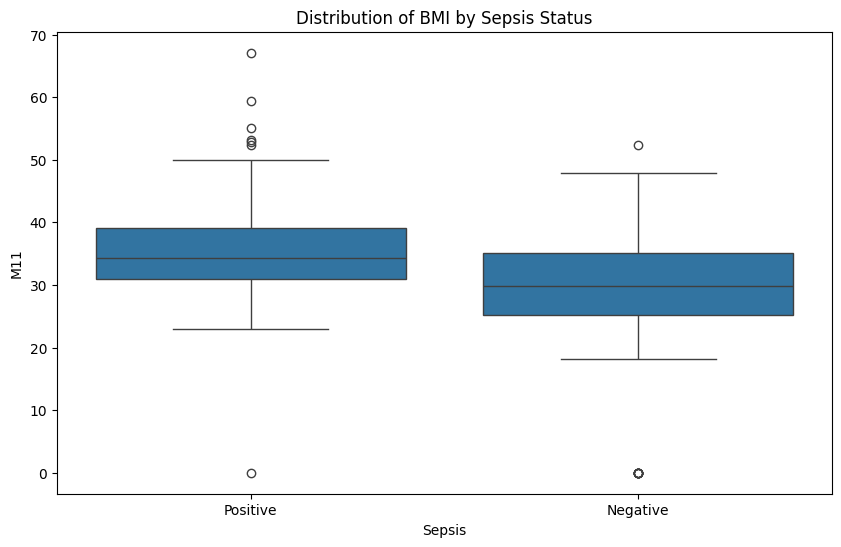

In [24]:

# Check unique values in the 'Sepssis' column
print(df_train['Sepssis'].unique())

# Remove any missing values in the 'BMI' column
df_train.dropna(subset=['M11'], inplace=True)

# Visualize the distribution of BMI by Sepsis status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sepssis', y='M11', data=df_train)
plt.title('Distribution of BMI by Sepsis Status')
plt.xlabel('Sepsis')
plt.ylabel('M11')
plt.show()

##### Question 3: Does the duration of ICU stay differ between patients who develop sepsis and those who do not?

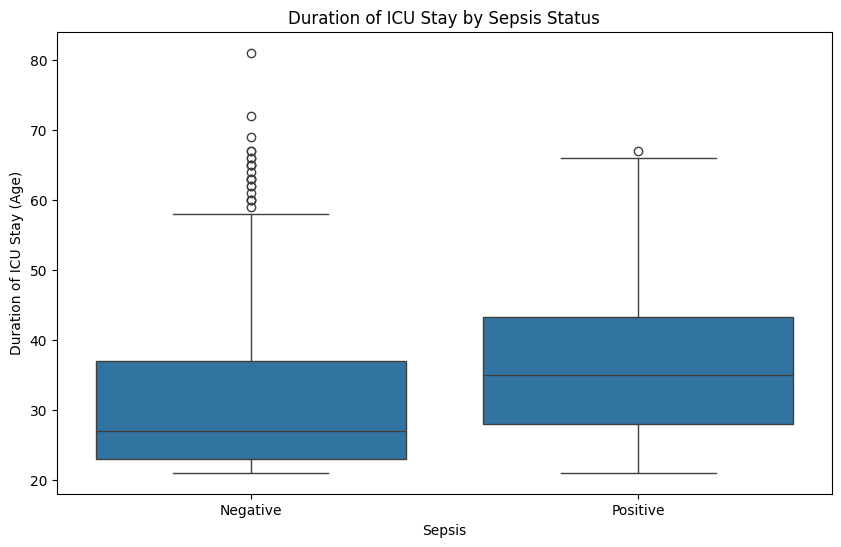

In [25]:
df_train['Age'] = df_train['Age'].astype(int)

# Visualize the distribution of duration of ICU stay by Sepsis status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sepssis', y='Age', data=df_train, order=["Negative", "Positive"])
plt.title('Duration of ICU Stay by Sepsis Status')
plt.xlabel('Sepsis')
plt.ylabel('Duration of ICU Stay (Age)')
plt.show()

##### Question 4: How does the distribution of body mass index (BMI) differ between patients who have insurance and those who do not?

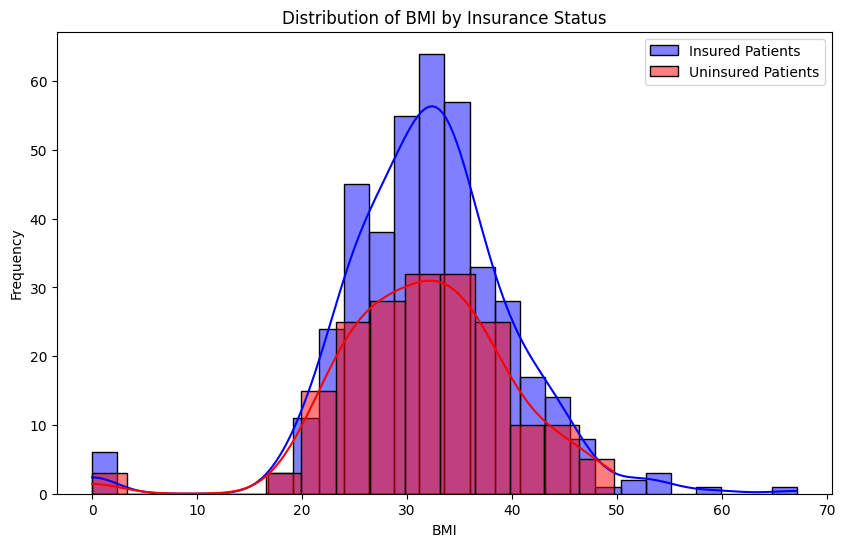

In [26]:
# Separate data into two groups based on insurance status
insured_patients = df_train[df_train['Insurance'] == 'Yes']['M11']
uninsured_patients = df_train[df_train['Insurance'] == 'No']['M11']

# Plot the distribution of BMI for insured and uninsured patients
plt.figure(figsize=(10, 6))
sns.histplot(insured_patients, color='blue', kde=True, label='Insured Patients')
sns.histplot(uninsured_patients, color='red', kde=True, label='Uninsured Patients')
plt.title('Distribution of BMI by Insurance Status')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()
plt.show()

##### Question 5:Is there a significant difference in the average age between patients who develop sepsis and those who do not?

In [27]:
# Separate data into groups based on Sepsis status
sepsis_positive = df_train[df_train['Sepssis'] == 'Positive']
sepsis_negative = df_train[df_train['Sepssis'] == 'Negative']

# Perform independent t-test
t_statistic, p_value = ttest_ind(sepsis_positive['Age'], sepsis_negative['Age'])

# Define significance level
alpha = 0.05

# Print the results
print("Independent t-test results:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("There is a significant difference in the average age between patients who develop sepsis and those who do not.")
else:
    print("There is no significant difference in the average age between patients who develop sepsis and those who do not.")

Independent t-test results:
T-statistic: 5.254202967191448
P-value: 2.0718778891881853e-07
There is a significant difference in the average age between patients who develop sepsis and those who do not.


##### Question 6: Is there a correlation between BMI and the risk of developing sepsis?

In [28]:
# Convert 'M11' column to numeric data type
# df_train['M11'] = pd.to_numeric(df_train['M11'])

# Convert 'Sepssis' column to binary encoding (1 for Positive, 0 for Negative)
df_train['Sepssis'] = df_train['Sepssis'].map({'Positive': 1, 'Negative': 0})

# Calculate correlation coefficient
correlation_coefficient = df_train[['M11', 'Sepssis']].corr().iloc[0, 1]

# Print the correlation coefficient
print("Correlation coefficient between BMI and the risk of developing sepsis:", correlation_coefficient)

Correlation coefficient between BMI and the risk of developing sepsis: 0.315893779268551


##### Insight
A correlation coefficient of 0.315 suggests a moderate positive correlation between BMI and the risk of developing sepsis. This means that higher BMI values are associated with a higher risk of developing sepsis, but the relationship is not extremely strong.

---

#### `Hypothesis Testing`
##### Null Hypothesis (H0): There is no significant difference in blood work results for patients who develop sepsis compared to those who do not
##### Alternative Hypothesis (H1): There is a significant difference in blood work results for patients who develop sepsis compared to those who do not

In [29]:
from scipy.stats import ttest_ind
from scipy import stats


In [30]:
# Separate data into groups based on Sepsis status
sepsis_positive = df_train[df_train['Sepssis'] == 'Positive']
sepsis_negative = df_train[df_train['Sepssis'] == 'Negative']

# Perform t-tests for each blood work result
blood_work_results = ['PL', 'PR', 'SK', 'TS', 'BD2']
for result in blood_work_results:
    t_stat, p_val = ttest_ind(sepsis_positive[result], sepsis_negative[result])
    print(f"T-test results for {result}:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_val}")
     # Define significance level (alpha)
    alpha = 0.05
    
    # Determine if the null hypothesis should be rejected
    if p_val < alpha:
        print("Significant difference detected. Null hypothesis rejected.")
    else:
        print("No significant difference detected. Fail to reject null hypothesis.")
    
    print()

T-test results for PL:
T-statistic: nan
P-value: nan
No significant difference detected. Fail to reject null hypothesis.

T-test results for PR:
T-statistic: nan
P-value: nan
No significant difference detected. Fail to reject null hypothesis.

T-test results for SK:
T-statistic: nan
P-value: nan
No significant difference detected. Fail to reject null hypothesis.

T-test results for TS:
T-statistic: nan
P-value: nan
No significant difference detected. Fail to reject null hypothesis.

T-test results for BD2:
T-statistic: nan
P-value: nan
No significant difference detected. Fail to reject null hypothesis.



---

#### `Data Preparation`

##### 1. Split the dataset into X and y test features

In [31]:
X = df_train.drop('Sepssis', axis=1)
y = df_train['Sepssis']

##### 2. Split data set into training and evaluation sets

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 3. Feature Processing and Engineering

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PRG        599 non-null    int64  
 1   PL         599 non-null    int64  
 2   PR         599 non-null    int64  
 3   SK         599 non-null    int64  
 4   TS         599 non-null    int64  
 5   M11        599 non-null    float64
 6   BD2        599 non-null    float64
 7   Age        599 non-null    int32  
 8   Insurance  599 non-null    object 
dtypes: float64(2), int32(1), int64(5), object(1)
memory usage: 39.9+ KB


In [34]:
# Separating input features into numeric and categorical for different pipelines
numeric_column = X.select_dtypes(include=['number']).columns
numeric_column

Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'], dtype='object')

In [35]:
categorical_column = X.select_dtypes(include=['object']).columns
categorical_column

Index(['Insurance'], dtype='object')

In [36]:
class LogTransformer:
    def __init__(self, constant=1e-5):
        self.constant = constant

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log1p(X + self.constant)

# Numeric pipeline
numerical_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('log_transformation', FunctionTransformer(LogTransformer().transform)),
    ('scaler', RobustScaler()),
    
])



# Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

# Combine the numeric and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('numerical_pipeline', numerical_pipeline, numeric_column),
    ('categorical_pipeline', categorical_pipeline, categorical_column),
])


#### Label Encoding

In [37]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training set
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the testing set using the fitted label encoder
y_test_encoded = label_encoder.transform(y_test)

In [38]:
joblib.dump(label_encoder, 'models/encoder.joblib')

['models/encoder.joblib']

---

### <b> `Evaluation`

#### Model 1: RandomForestClassifier

In [39]:
# Create a pipeline with preprocessor and RandomForestClassifier
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42,))
])

# Fit the pipeline to the training data
random_forest_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x00000231D8817310>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Insurance'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

#### Model 2: Logistic Regression

In [40]:
# Create a pipeline for Logistic Regression
logistic_regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the pipeline to the training data for Logistic Regression
logistic_regression_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x00000231D8817310>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Insurance'], dtype='object'))])),
                ('classifier', LogisticRegression(random_state=42))])

#### Model 3: K NNeighbors

In [41]:
# Create a pipeline with preprocessor and KNeighborsClassifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Fit the pipeline to the training data
knn_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x00000231D8817310>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Insurance'], dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

#### Comparing Models by Classification reports - Unbalanced

In [42]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'K Nearest Neighbors': KNeighborsClassifier(),
}

In [43]:
# Create an empty DataFrame to store evaluation metrics for different models
unbalanced_metrics = pd.DataFrame(columns=['Model_name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Iterate over models dictionary, where each item is a model_name: classifier pair
for model_name, classifier in models.items():
    # Create a pipeline with preprocessing steps and the current classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train_encoded)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
    # Compute classification metrics using the classification_report
    metrics = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Extract individual metrics for evaluation
    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1_score = metrics['weighted avg']['f1-score']
    
    # Append the model's evaluation metrics to the DataFrame
    unbalanced_metrics.loc[len(unbalanced_metrics)] = [model_name, accuracy, precision, recall, f1_score]

In [44]:
unbalanced_metrics

,Model_name,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.716667,0.716667,0.716667,0.716667
1,Logistic Regression,0.750000,0.744627,0.750000,0.745313
2,K Nearest Neighbors,0.750000,0.745885,0.750000,0.747067


#### Balancing Dataset

In [45]:
y_train.info

<bound method Series.info of 145    0
9      1
375    1
522    0
188    1
      ..
71     0
106    0
270    1
435    1
102    0
Name: Sepssis, Length: 479, dtype: int64>

In [46]:
y_train.value_counts()

Sepssis
0    314
1    165
Name: count, dtype: int64

. As you can see above the data is not balanced. No is the majority.

. Unbalanced data can lead to a bias in machine learning models toward the majority class, impacting overall performance.

. To address these challenges, various techniques can be employed, including: Resampling techniques (oversampling minority or undersampling majority class).

#### Balancing by Resampling by applying RandomOverSampler

In [47]:

#Balance data by oversampling

# Instantiate RandomOverSampler
sampler = RandomOverSampler(random_state=42)

# Fit and apply RandomOverSampler to the training data
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train_encoded)

In [48]:
#checking if data is balanced
pd.DataFrame(y_train_resampled).value_counts()

0
0    314
1    314
Name: count, dtype: int64

##### Check the classification reports after balancing data to see if the there is some improvement on the models.

In [49]:
    
# Create an empty DataFrame to store evaluation metrics for different models
balanced_metrics = pd.DataFrame(columns=['Model_name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Iterate over models dictionary, where each item is a model_name: classifier pair
for model_name, classifier in models.items():
    # Create a pipeline with preprocessing steps and the current classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
    
     # Fit the pipeline to the training data (resampled)
    pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
    # Compute classification metrics using the classification_report
    metrics = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    # Extract individual metrics for evaluation
    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1_score = metrics['weighted avg']['f1-score']
    
    # Append the model's evaluation metrics to the DataFrame
    balanced_metrics.loc[len(unbalanced_metrics)] = [model_name, accuracy, precision, recall, f1_score]

In [50]:
balanced_metrics

,Model_name,Accuracy,Precision,Recall,F1 Score
3,K Nearest Neighbors,0.675,0.703292,0.675,0.681356


Insights

. Logistic Regression:Balancing resulted in a decrease in accuracy from 75.00% to 68.33%. Same as precision and recall dropped, leading to a lower F1 score.

. Random Forest:Balancing resulted in a slight improvement in accuracy from 71.67% to 72.50%. Same as precision and recall improved, leading to an improvedF1 score.

#### Balancing data using SMOTE, training it and comparing results

In [51]:

# Initialize an empty DataFrame to store results
smote_df = pd.DataFrame(columns=['Model_name', 'Accuracy', 'Precision', 'Recall', 'F1_Score'])

# Iterate over each model and apply SMOTE during training
for model_name, classifier in models.items():
    # Create a pipeline with preprocessing, SMOTE, and the classifier
    pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', classifier)
    ])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train_encoded)
    
    # Make predictions on the test data
    smote_y_pred = pipeline.predict(X_test)
    
    # Calculate classification metrics using classification_report
    smote_dict = classification_report(y_test_encoded, smote_y_pred, output_dict=True)
    
    # Extract relevant metrics
    accuracy = smote_dict['accuracy']
    precision = smote_dict['weighted avg']['precision']
    recall = smote_dict['weighted avg']['recall']
    f1_score = smote_dict['weighted avg']['f1-score']
    
    # Append the results to the DataFrame
    smote_df.loc[len(smote_df)] = [model_name, accuracy, precision, recall, f1_score]

# Print the results DataFrame
print(smote_df)



            Model_name  Accuracy  Precision    Recall  F1_Score
0        Random Forest  0.725000   0.733391  0.725000  0.727941
1  Logistic Regression  0.683333   0.703656  0.683333  0.688831
2  K Nearest Neighbors  0.666667   0.697856  0.666667  0.673333


#### Feature importance and Selection

In [52]:
pd.DataFrame(preprocessor.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9
0,-1.106587,-0.357061,0.323008,0.000000,-0.774339,-11.546261,0.449933,-0.597839,0.0,1.0
1,0.647314,0.248407,1.481018,-0.905058,-0.774339,-11.546261,-0.446469,1.168356,0.0,1.0
2,0.940846,0.586292,0.741198,0.172618,0.432323,0.651727,0.345514,1.303678,0.0,1.0
3,0.446706,-0.026009,-20.232257,-0.905058,-0.774339,-11.546261,-0.577140,-0.203087,0.0,1.0
4,0.647314,-0.159543,0.385053,0.145475,0.215056,-0.438094,0.605694,0.124401,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
474,0.323657,0.564911,-0.419070,0.115470,0.257557,-0.359063,0.052508,-0.203087,0.0,1.0
475,-0.553294,-0.537356,2.608157,-0.905058,-0.774339,-1.135214,-0.521874,-0.132987,0.0,1.0
476,0.807497,-0.386368,0.964599,0.130868,-0.774339,1.139578,1.577606,0.505720,1.0,0.0
477,-1.106587,0.607522,-20.232257,-0.905058,-0.774339,0.904653,-0.527974,0.000000,0.0,1.0


In [53]:

# Feature selection using SelectKBest
selection = SelectKBest(mutual_info_classif, k=30)
fi_smote_df = pd.DataFrame(columns=['Model_name', 'Accuracy', 'Precision', 'Recall', 'F1_Score'])

all_pipeline ={}

for model_name, classifier in models.items():
    pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('feature_importance', selection),
        ('classifier', classifier)
    ])
    
    pipeline.fit(X_train, y_train_encoded)

    all_pipeline[model_name] = pipeline

    smote_y_pred = pipeline.predict(X_test)
    
    fi_smote_dict = classification_report(y_test_encoded, smote_y_pred, output_dict=True)
    
    accuracy = fi_smote_dict['accuracy']
    precision = fi_smote_dict['weighted avg']['precision']
    recall = fi_smote_dict['weighted avg']['recall']
    f1_score = fi_smote_dict['weighted avg']['f1-score']
    
    fi_smote_df.loc[len(fi_smote_df)] = [model_name, accuracy, precision, recall, f1_score]


In [54]:
fi_smote_df

,Model_name,Accuracy,Precision,Recall,F1_Score
0,Random Forest,0.725000,0.733391,0.725000,0.727941
1,Logistic Regression,0.683333,0.703656,0.683333,0.688831
2,K Nearest Neighbors,0.666667,0.697856,0.666667,0.673333


MOdel Persistence

In [55]:
for model_name, pipeline in models.items():
    joblib.dump(pipeline, f'models/{model_name}_pipeline.joblib')

#### Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC)- Overlapping

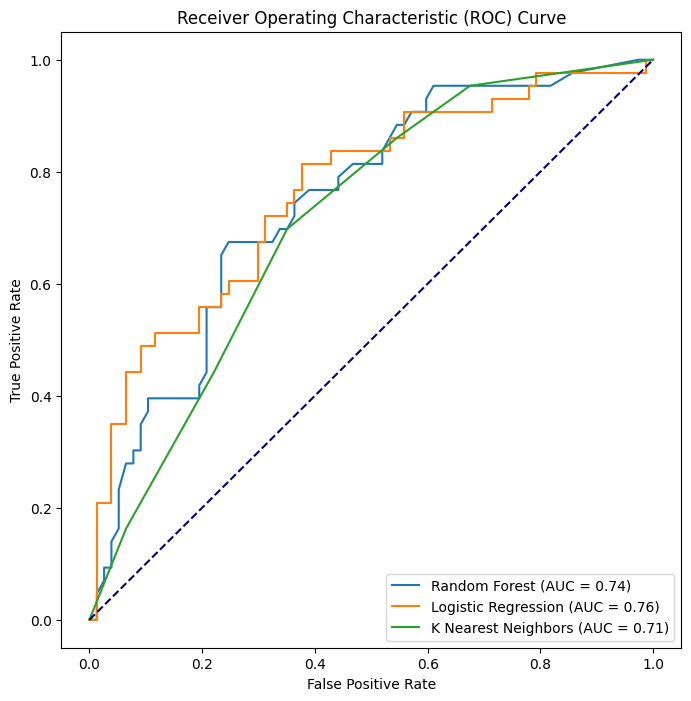

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create a plot with subplots
fig, ax = plt.subplots(figsize=(8, 8))

roc_curve_data = {}
all_pipeline = {}

# Loop through models to plot ROC curves
for model_name, classifier in models.items():
    # Assuming 'preprocessor', 'SMOTE', 'selection' are defined earlier
    pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('feature_importance', selection),
        ('classifier', classifier)
    ])

    # Fit the pipeline to training data
    pipeline.fit(X_train, y_train_encoded)

    # Get predicted probabilities for positive class
    y_score = pipeline.predict_proba(X_test)[:, 1]
    all_pipeline[model_name] = pipeline
    # Calculate ROC curve and AUC
    fpr, tpr, threshold= roc_curve(y_test_encoded, y_score)
    roc_auc = auc(fpr, tpr)

    roc_curve_df =pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Threshold': threshold})

    roc_curve_data[model_name] = roc_curve_df

    # Plot ROC curve
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for reference
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Set labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')

# Add legend in the lower right corner
ax.legend(loc='lower right')

# Show the plot
plt.show()


The best-performing model based on AUC is **Logistic Regression**, as it has the highest AUC value (0.76), indicating superior performance in classification tasks.

In [57]:
# Checking the threshold
roc_curve_data['Random Forest'].tail(40)

,False Positive Rate,True Positive Rate,Threshold
19,0.207792,0.441860,0.67
20,0.207792,0.465116,0.65
21,0.207792,0.511628,0.64
22,0.207792,0.558140,0.61
23,0.233766,0.558140,0.59
24,0.233766,0.604651,0.55
25,0.233766,0.651163,0.53
26,0.246753,0.674419,0.52
27,0.272727,0.674419,0.50
28,0.311688,0.674419,0.47


Confusion Matrix

In [58]:
# Retrieve the 'Random Forest' pipeline

forest_pipeline = all_pipeline['Random Forest']  
# Make predictions using the pipeline
forest_y_pred = forest_pipeline.predict(X_test)  

# Calculate the confusion matrix
matrix = confusion_matrix(y_test_encoded, forest_y_pred)

# Print or use the 'matrix' variable as needed
print(matrix)


[[58 19]
 [14 29]]


<Axes: >

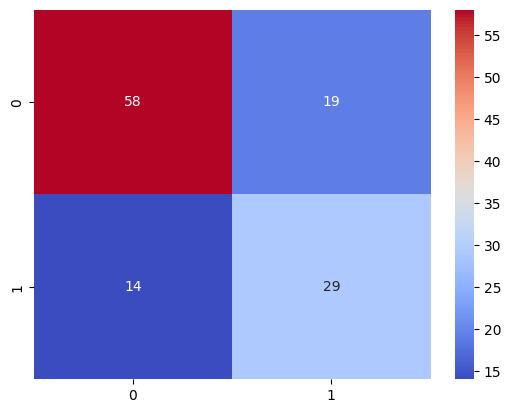

In [59]:
sns.heatmap(data=matrix, annot=True, fmt='d', cmap='coolwarm')

Adjusting threshold

In [60]:
y_pred_proba = forest_pipeline.predict_proba(X_test)[:, 1]

# Set the threshold
threshold = 0.16

# Create binary predictions based on the threshold
binary_prediction = (y_pred_proba > threshold).astype(int)

# Calculate the confusion matrix with the threshold
threshold_matrix = confusion_matrix(y_test_encoded, binary_prediction)

# Print or use the 'threshold_matrix' variable as needed
print(threshold_matrix)


[[31 46]
 [ 3 40]]


### Hyperparameter Tuning and Retraining with RandomizedSearchCV and GridSearchCV


In [61]:
# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [10, 30,50 ],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Create the grid search
grid_search = GridSearchCV(forest_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train_encoded)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_pipeline',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('log_transformation',
                                                                                          FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x00000231D8817310>>)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['PRG', 'PL', 'P...
                                       ('feature_importance',
                                        SelectKBest(k=30,
                                                    score_func=<function mutual_info_classif at 0x00000231D2068720>)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [10, 30, 50]},
             scoring='accuracy')

In [62]:
# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


#### Train model using best parameters

In [63]:
# Define the pipeline with the RandomForest classifier
forest_pipeline = imbpipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_importance', selection),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid with the best parameters
best_params = {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

# Set the best parameters to the pipeline
forest_pipeline.set_params(**best_params)

# Fit the pipeline to the training data
forest_pipeline.fit(X_train, y_train_encoded)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transformation',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x00000231D8817310>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Ag...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Insurance'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('feature_importance',
                 SelectKBest(k=30,
                             score_func=<function mutual_info_classif at 0x00000231D2068720>)),
                ('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=200,
                                        random_state=42))])

#### Evaluation result

In [64]:
# Make predictions using the new pipeline
forest_y_pred_best = forest_pipeline.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_encoded, forest_y_pred_best))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        77
           1       0.62      0.72      0.67        43

    accuracy                           0.74       120
   macro avg       0.72      0.74      0.73       120
weighted avg       0.75      0.74      0.75       120



In [65]:
predictions = forest_pipeline.predict(df_test)

# Create a new dataframe to combine the test data with the predictions
combined_df = pd.DataFrame({'Predicted_Label': predictions})

# Concatenate the original test dataframe and the new dataframe with predictions
result_df = pd.concat([df_test.reset_index(drop=True), combined_df], axis=1)

# Save the combined dataframe to a CSV file
result_df.to_csv('combined_data.csv', index=False)